## Imports

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, Dense, LeakyReLU, Dropout, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler

import pymongo
from pymongo import MongoClient

from subprocess import check_output

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# stock_name = 'فاسمين'
# stock_name = 'شدوص'
stock_name = 'خاذين'
# stock_name = 'خزر'
# stock_name = 'حريل'
# stock_name = 'كگل'
print(stock_name)

خاذين


## Get Data from Mongo

In [227]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query).sort([("date", pymongo.ASCENDING)])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']
    
    # df = df[['date', 'open', 'high', 'low', 'close']].rename(columns=str.capitalize)
    df = df[['date', 'vol', 'open', 'high', 'low', 'close']].rename(columns={'vol': 'volume'})
    
    def dateChange(y):
        x = str(y)
        return x[0:4] + '-' + x[4:6] + '-' + x[6:8]
    
    df['date'] = df['date'].apply(dateChange)
    return df

## Getting the Stock prices history from mongo

In [228]:
df = read_mongo('bors', 'stock', query={ 'name': stock_name }, username='bors', password='C26JntThhCAUGYPx')
df.drop(['date'],1,inplace=True)
df['diff_vol'] = df[['volume']].diff()
df.loc[0, 'diff_vol'] = df.loc[0, 'volume']
df['diff_close'] = df[['close']].diff()
df.loc[0, 'diff_close'] = 0
df['dvol*dclose'] = df['diff_vol'] * df['diff_close']
df['dclose/dvol'] = df['diff_close'] / df['diff_vol']
cor_mat = df.corr()

df.head()

volume  open  high   low  close   diff_vol  diff_close  dvol*dclose  \
0  1880000  4512  4531  4500   4500  1880000.0         0.0          0.0   
1   124300  4500  4552  4500   4552 -1755700.0        52.0  -91296400.0   
2    22900  4552  4553  4520   4552  -101400.0         0.0         -0.0   
3    67000  4552  4556  4551   4552    44100.0         0.0          0.0   
4    31200  4552  4620  4552   4620   -35800.0        68.0   -2434400.0   

   dclose/dvol  
0     0.000000  
1    -0.000030  
2    -0.000000  
3     0.000000  
4    -0.001899

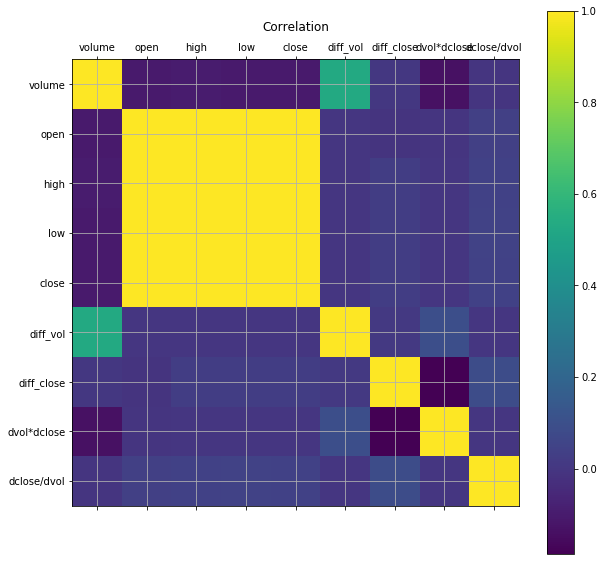

In [229]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
cax = ax1.matshow(cor_mat)
plt.title('Correlation')
plt.grid(True)
labels=np.concatenate(([''], df.columns.values), axis=0)
ax1.set_xticklabels(labels)
ax1.set_yticklabels(labels)
fig.colorbar(cax)
plt.show()

## Plot the stock

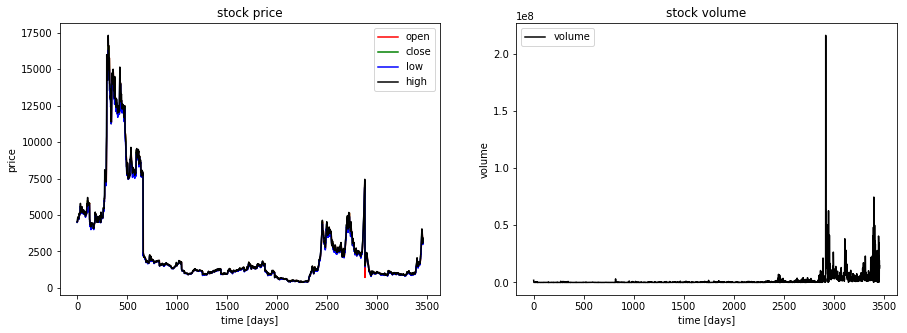

In [230]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

## Manipulate data

In [231]:
# save size of df
df_stock = df
df_size = df.shape[0]

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['volume', 'open', 'high', 'low', 'close', 'diff_vol', 'diff_close', 'dvol*dclose', 'dclose/dvol']


In [232]:
# function for min-max normalization of stock
seq_len = 16 # choose sequence length (16 is 1 month)

def windowed_norimilize(df):
    for j in cols:
        df[j] = df[j].astype(float)
        data = []
        for index in range(0, df.shape[0], seq_len):
            data[index:index + seq_len] = min_max_scaler.fit_transform(df[j][index:index + seq_len].values.reshape(-1,1))
        df[j] = data
    return df

def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    close_scaler = MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = close_scaler.fit_transform(df['close'].values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['diff_vol'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['diff_close'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['dvol*dclose'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['dclose/dvol'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    return df

In [233]:
# normalize stock
df_inner = df_stock.copy()
# df_inner = windowed_norimilize(df_inner)
df_inner = normalize_data(df_inner)
# df_stock_norm.open[0]

# function to create train, validation, test data given stock data and sequence length
shift = 4

def smooth_data(dt, length, smooth_size2):
    for col in cols:
        if col == 'dclose/dvol':
            lent = 0
            continue;
        if col in ['diff_close', 'dvol*dclose']:
            lent = smooth_size2
        else:
            lent = length
        EMA = 0.0
        gamma = 0.1
        for ti in range(lent):
          EMA = gamma*dt.loc[ti, col] + (1-gamma)*EMA
          dt.loc[ti, col] = EMA
    return dt

def load_data(stock, target, seq_len):
    data_raw = stock.values # convert to numpy array
    data_len = len(data_raw) - seq_len
    
    train_perc = 100 - valid_set_size_percentage - test_set_size_percentage;
    train_set_size = int(np.round(train_perc / 100 * (data_len)))
    train_set_size = int(np.round(train_set_size / seq_len) * seq_len)
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data_len));  
    valid_set_size = int(np.ceil(valid_set_size / seq_len) * seq_len)
    test_set_size = data_len - (train_set_size + valid_set_size)
    
    smooth_size = train_set_size + seq_len + shift
    smooth_size2 = train_set_size + valid_set_size + test_set_size + seq_len
    
    # smooth target
    EMA = 0.0
    gamma = 0.1
    for ti in range(smooth_size):
      EMA = gamma*target[ti] + (1-gamma)*EMA
      target[ti] = EMA
    # smooth train and valid data
#     sm_data = smooth_data(stock, smooth_size, smooth_size2)
    df_stock_norm = normalize_data(stock)
    data_raw = df_stock_norm.values
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    
    x_train = data[:train_set_size]
    y_train = target[seq_len + shift:train_set_size + seq_len + shift]
    yz_train = data_raw[seq_len + shift:train_set_size + seq_len + shift]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:]
    y_valid = target[train_set_size + seq_len + shift:train_set_size + valid_set_size + seq_len + shift]
    yz_valid = data_raw[train_set_size + seq_len + shift:train_set_size + valid_set_size + seq_len + shift]
    
    x_test = data[train_set_size + valid_set_size:]
    y_test = target[train_set_size + valid_set_size + seq_len + shift:]
    yz_test = data_raw[train_set_size + valid_set_size + seq_len + shift:]
    
    final_set_size = int(np.floor((data.shape[0] - seq_len) / seq_len) * seq_len)
    x_final = data[data.shape[0] - final_set_size:]
    
    return x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final, df_stock_norm

x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final, df_stock_norm = load_data(
    df_inner, df_inner.copy()['close'], seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('yz_train.shape = ', yz_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('yz_valid.shape = ', yz_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print('yz_test.shape = ',yz_test.shape)
print('x_final.shape = ',x_final.shape)
print('df.size = ',df_size)

x_train.shape =  (2752, 16, 9)
y_train.shape =  (2752,)
yz_train.shape =  (2752, 9)
x_valid.shape =  (352, 16, 9)
y_valid.shape =  (352,)
yz_valid.shape =  (352, 9)
x_test.shape =  (339, 16, 9)
y_test.shape =  (335,)
yz_test.shape =  (335, 9)
x_final.shape =  (3424, 16, 9)
df.size =  3459


/home/vahid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Plot normalized data

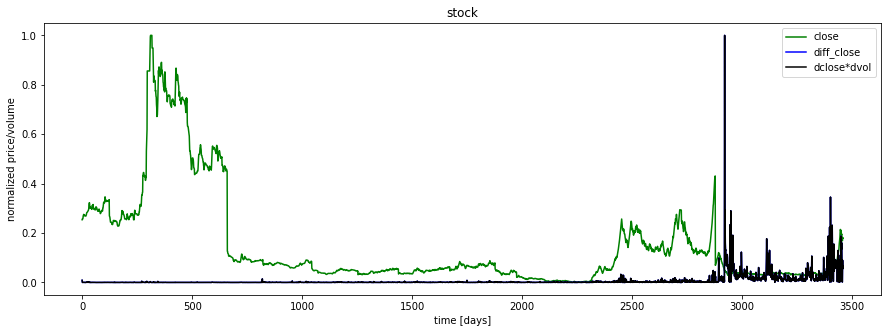

In [234]:
plt.figure(figsize=(15, 5));
# plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.plot(df_stock_norm.diff_close.values, color='blue', label='diff_close')
plt.plot(df_stock_norm[['dclose/dvol']].values, color='black', label='dclose*dvol')
# plt.plot(df_stock_norm.low.values, color='blue', label='low')
# plt.plot(df_stock_norm.high.values, color='black', label='high')
# plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [235]:
days = df_stock.copy().values[-16:]
days = smooth_data(days, days.shape[0], days.shape[0])
days = days[-16:,4]

plt.figure(figsize=(15, 5));
plt.plot(days)
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

## Model and validate data

In [236]:
#Build the model
reg = regularizers.l2(0.01)
epochs = 20
units = 100
future_days_predict = seq_len

model = Sequential ()
model.add (LSTM (units,
                 activation = 'tanh',
                 recurrent_activation = 'hard_sigmoid',
                 return_sequences=True,
                 input_shape =(seq_len, len(cols)) ))
model.add(Dropout(0.2))
model.add (LSTM (int(units * 2),
                 return_sequences=False,
                 activation = 'tanh',
                 recurrent_activation = 'hard_sigmoid',
                 input_shape =(seq_len, len(cols)) ))
model.add(Dropout(0.2))
model.add (Dense (units =len(cols)))
model.add (Dense (units =1, activation = 'linear'))
model.compile (loss ="mse" , optimizer = "adam") 

# model = Sequential()
# model.add(LSTM(units = units, activation = 'tanh', input_shape = (seq_len - 1, 5), return_sequences = False))
# model.add(Dropout(0.8))
# model.add(Dense(5))
# model.add(LeakyReLU())
# model.compile(loss='mse', optimizer='adam')

# use with gpu

# model.add(CuDNNLSTM(units = units, bias_regularizer = reg, input_shape = (seq_len - 1, 5), return_sequences=False))
# model.add(Activation('tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(5))
# model.add(LeakyReLU())
# model.compile(loss='mse', optimizer='adam')

#Fit the model
history = model.fit(x_train, y_train, batch_size = seq_len, validation_data=(x_valid, y_valid), epochs = epochs)

Train on 2752 samples, validate on 352 samples
Epoch 1/20
2752/2752 [==============================] - 8s 3ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 2/20
2752/2752 [==============================] - 4s 1ms/step - loss: 7.0344e-04 - val_loss: 0.0037
Epoch 3/20
2752/2752 [==============================] - 4s 1ms/step - loss: 6.0096e-04 - val_loss: 0.0038
Epoch 4/20
2752/2752 [==============================] - 4s 1ms/step - loss: 4.7690e-04 - val_loss: 0.0043
Epoch 5/20
2752/2752 [==============================] - 4s 1ms/step - loss: 4.7700e-04 - val_loss: 0.0050
Epoch 6/20
2752/2752 [==============================] - 4s 1ms/step - loss: 4.7490e-04 - val_loss: 0.0049
Epoch 7/20
2752/2752 [==============================] - 4s 1ms/step - loss: 5.5836e-04 - val_loss: 0.0046
Epoch 8/20
2752/2752 [==============================] - 4s 1ms/step - loss: 5.0569e-04 - val_loss: 0.0053
Epoch 9/20
2752/2752 [==============================] - 4s 1ms/step - loss: 5.6043e-04 - val_loss: 0.0076
Epo

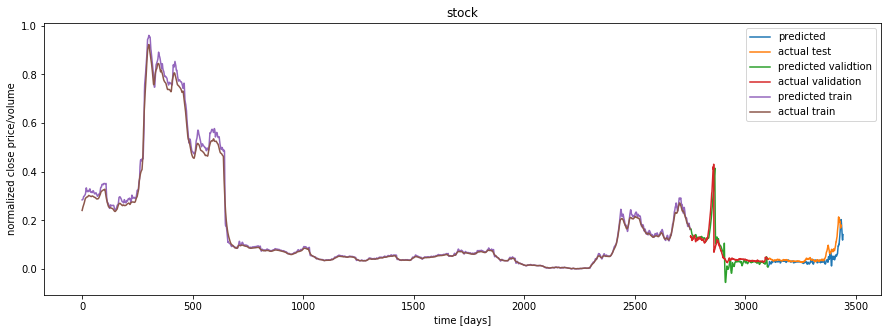

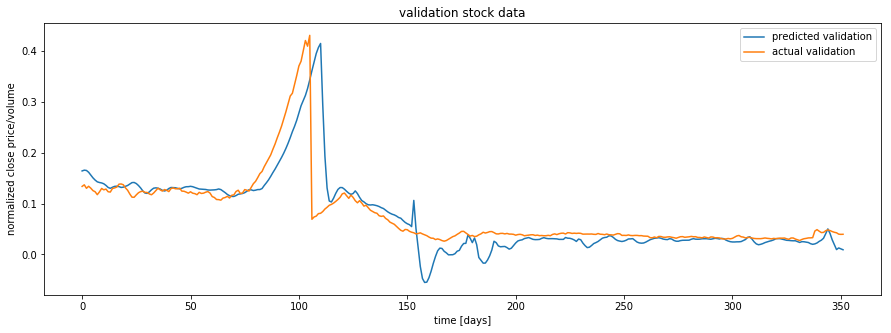

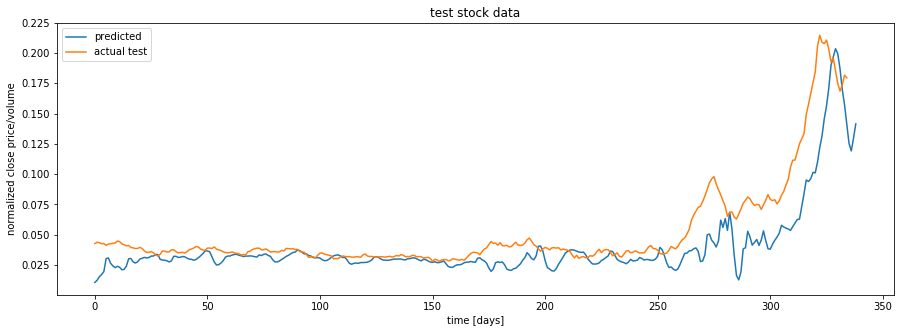

In [237]:
Xt = model.predict(x_test)
Xt_val = model.predict(x_valid)
Xt_tr = model.predict(x_train)

plt.figure(figsize=(15, 5));
plt.plot(
    range(x_train.shape[0] + x_valid.shape[0], x_train.shape[0] + x_valid.shape[0] + x_test.shape[0]),
    (Xt), label='predicted')
plt.plot(
    range(x_train.shape[0] + x_valid.shape[0] - shift, x_train.shape[0] + x_valid.shape[0] + x_test.shape[0] - 2*shift),
    (y_test.values), label='actual test')
plt.plot(
    range(x_train.shape[0], x_train.shape[0] + x_valid.shape[0]),
    (Xt_val), label='predicted validtion')
plt.plot(
    range(x_train.shape[0], x_train.shape[0] + x_valid.shape[0]),
    (y_valid.values), label='actual validation')
plt.plot((Xt_tr), label='predicted train')
plt.plot((y_train.values), label='actual train')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot((Xt_val), label='predicted validation')
plt.plot((y_valid.values), label='actual validation')

plt.title('validation stock data')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot((Xt), label='predicted')
plt.plot((y_test.values), label='actual test')

plt.title('test stock data')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

## #{shift} Days ahead prediction

In [238]:
x_test_final = x_final[:-shift]

predictions = model.predict(x_test_final, batch_size=seq_len)
print(x_final[-1, -1, 4] - x_final[-shift, -1, 4], predictions[-1] - predictions[-2])

0.0068467801628423475 [-0.01599459]


## Predictions

In [12]:
epochs = 15
units = 50

newModel = Sequential ()
newModel.add (LSTM (units,
                    activation = 'tanh',
                    batch_input_shape = (seq_len, seq_len, len(cols)),
                    stateful=True,
                    batch_size=seq_len,
                    recurrent_activation = 'hard_sigmoid',
                    return_sequences=True,
                    input_shape =(seq_len, len(cols)) ))
newModel.add(Dropout(0.2))
newModel.add (LSTM (int(units * 2),
                    activation = 'tanh',
                    batch_input_shape = (seq_len, seq_len, len(cols)),
                    stateful=True,
                    return_sequences=False,
                    batch_size=seq_len,
                    recurrent_activation = 'hard_sigmoid',
                    input_shape =(seq_len, len(cols)) ))
newModel.add(Dropout(0.2))
# newModel.add(Dense (units = 1, activation='linear'))
# newModel.add(Flatten())
newModel.add(Dense (units = len(cols)))
newModel.compile (loss ="mse" , optimizer = "adam") 

print(yz_train.shape)

newModel.fit(x_train, yz_train, batch_size = seq_len, validation_data=(x_valid, yz_valid), epochs = epochs)
newModel.reset_states()

(2496, 5)
Train on 2496 samples, validate on 320 samples
Epoch 1/15
2496/2496 [==============================] - 3s 1ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 2/15
2496/2496 [==============================] - 2s 769us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/15
2496/2496 [==============================] - 2s 753us/step - loss: 9.9716e-04 - val_loss: 0.0026
Epoch 4/15
2496/2496 [==============================] - 2s 756us/step - loss: 8.3101e-04 - val_loss: 0.0026
Epoch 5/15
2496/2496 [==============================] - 2s 761us/step - loss: 7.1760e-04 - val_loss: 0.0026
Epoch 6/15
2496/2496 [==============================] - 2s 760us/step - loss: 6.6243e-04 - val_loss: 0.0026
Epoch 7/15
2496/2496 [==============================] - 2s 739us/step - loss: 5.5357e-04 - val_loss: 0.0027
Epoch 8/15
2496/2496 [==============================] - 2s 758us/step - loss: 6.3221e-04 - val_loss: 0.0027
Epoch 9/15
2496/2496 [==============================] - 2s 769us/step - loss: 5.0104e-04 

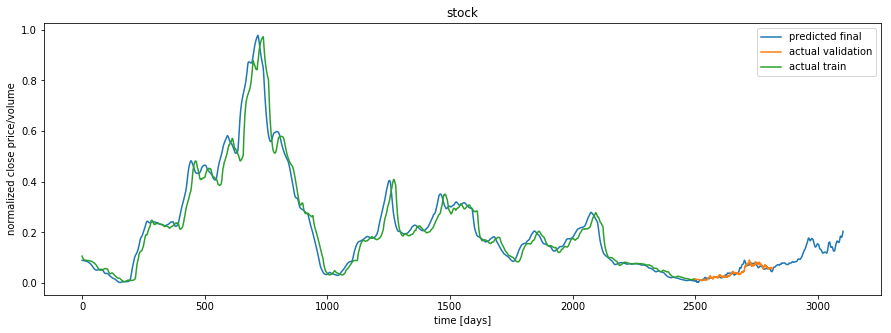

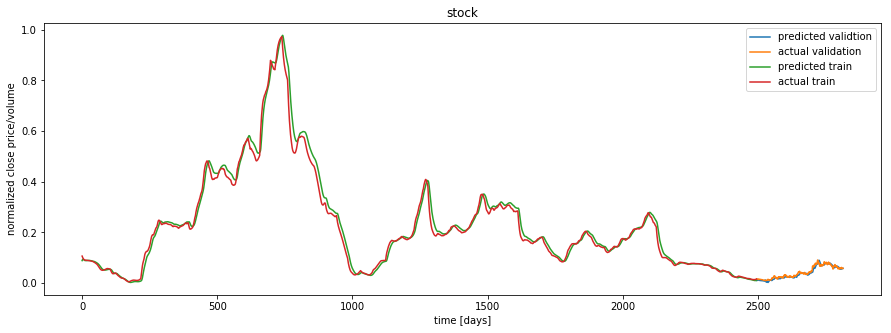

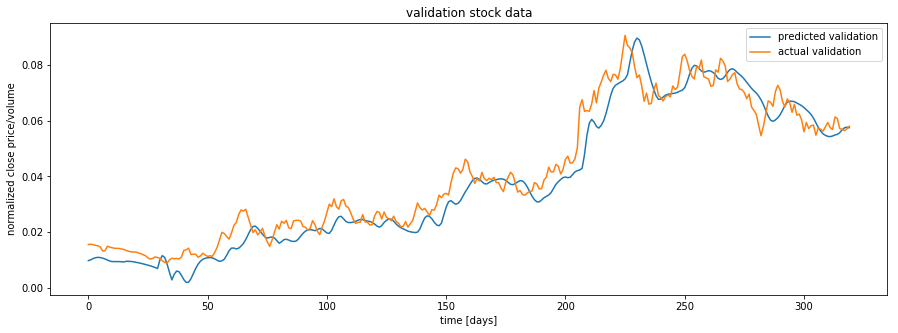

In [13]:
Xt_val = newModel.predict(x_valid, batch_size=seq_len)
newModel.reset_states()
Xt_tr = newModel.predict(x_train, batch_size=seq_len)
newModel.reset_states()

Xtf_tr = newModel.predict(x_final, batch_size=seq_len)
newModel.reset_states()

plt.figure(figsize=(15, 5));
plt.plot(
    range(x_final.shape[0]),
    (Xtf_tr[:,4]), label='predicted final')
plt.plot(
    range(x_train.shape[0], x_train.shape[0] + x_valid.shape[0]),
    (y_valid.values), label='actual validation')
plt.plot((y_train.values), label='actual train')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(
    range(x_train.shape[0], x_train.shape[0] + x_valid.shape[0]),
    (Xt_val[:,4]), label='predicted validtion')
plt.plot(
    range(x_train.shape[0], x_train.shape[0] + x_valid.shape[0]),
    (y_valid.values), label='actual validation')
plt.plot((Xt_tr[:, 4]), label='predicted train')
plt.plot((y_train.values), label='actual train')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot((Xt_val[:, 4]), label='predicted validation')
plt.plot((y_valid.values), label='actual validation')

plt.title('validation stock data')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

## Test the Theory of stateful lstm

In [25]:
future_days_predict = seq_len

def create_batch(step):
    data = []
    for index in range(len(step) - seq_len): 
        data.append(step[index: index + seq_len])
    return np.array(data)

x_test_final = x_final[:x_final.shape[0] - future_days_predict]

predictions = newModel.predict(x_test_final, batch_size=seq_len) #this creates states
close_predictions = predictions
last_step = predictions

future = []
fff = []
currentStep = create_batch(predictions) #last step from the previous prediction

step = 0
for i in range(future_days_predict + 1):
#     newModel.reset_states()
    currentStep = newModel.predict(currentStep, batch_size=seq_len) #get the next step
#     print(currentStep.shape)
    future.append(currentStep[-1,4]) #store the future steps
    fff.append(currentStep)
    last_step = currentStep
    currentStep = create_batch(currentStep)
    step = step + 1
    print('step ' + str(step) + ' is done')
    

#after processing a sequence, reset the states for safety
newModel.reset_states()

step 1 is done
step 2 is done
step 3 is done
step 4 is done
step 5 is done
step 6 is done
step 7 is done
step 8 is done
step 9 is done
step 10 is done
step 11 is done
step 12 is done
step 13 is done
step 14 is done
step 15 is done
step 16 is done
step 17 is done


In [26]:
close_index = 4

def get_close(dt):
    data = []
    for x in dt:
        data.append(x[close_index])
    return data

fft = np.array(fff)
ft = np.array(future)

ft1_close = np.array(last_step)
ft1_close = ft1_close[len(ft1_close) - future_days_predict:,4]

ft2_close = fft[fft.shape[0] - 2]
ft2_close = ft2_close[ft2_close.shape[0] - future_days_predict:,4]

ft3_close = fft[fft.shape[0] - 3]
ft3_close = ft3_close[ft3_close.shape[0] - future_days_predict:,4]

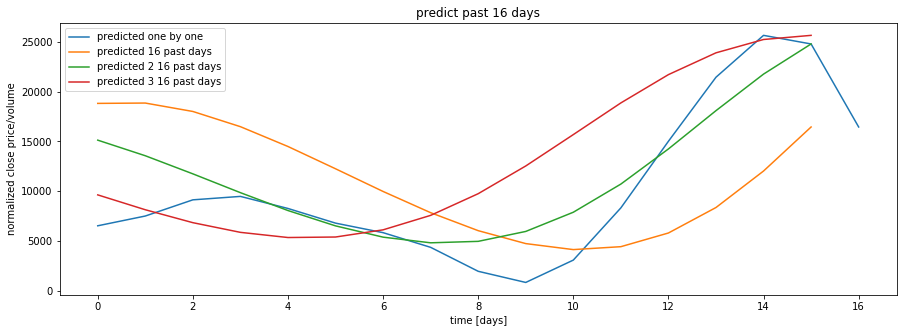

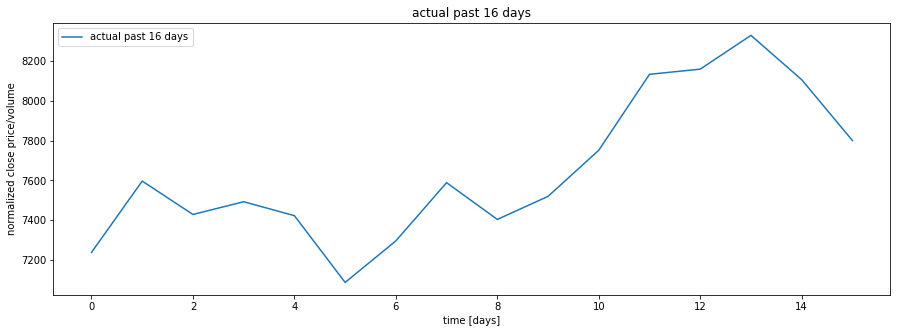

In [27]:
def close_normal(dt):
    data = []
    for x in dt:
        data.append([x])
    return data

plt.figure(figsize=(15, 5));
plt.plot(close_scaler.inverse_transform(close_normal(ft)), label='predicted one by one')
plt.plot(close_scaler.inverse_transform(close_normal(ft1_close)), label='predicted 16 past days')
plt.plot(close_scaler.inverse_transform(close_normal(ft2_close)), label='predicted 2 16 past days')
plt.plot(close_scaler.inverse_transform(close_normal(ft3_close)), label='predicted 3 16 past days')
# plt.plot(close_scaler.inverse_transform(close_normal(y_test.values[y_test.shape[0] - 1 * future_days_predict:])), label='actual past 16 days')
plt.title('predict past 16 days')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(close_scaler.inverse_transform(close_normal(y_test.values[y_test.shape[0] - 1 * future_days_predict:])), label='actual past 16 days')
plt.title('actual past 16 days')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

## Create stateful Prediction

In [17]:
print(x_final.shape)
future_days_predict = seq_len

def create_batch(step):
    data = []
    for index in range(len(step) - seq_len): 
        data.append(step[index: index + seq_len])
    return np.array(data)

predictions = newModel.predict(x_final, batch_size=seq_len) #this creates states
close_predictions = predictions
last_step = predictions

future = []
p_future = []
currentStep = create_batch(predictions) #last step from the previous prediction

step = 0
for i in range(future_days_predict):
    currentStep = newModel.predict(currentStep, batch_size=seq_len) #get the next step
    future.append(currentStep) #store the future steps  
    last_step = currentStep
    p_future.append(currentStep[-1,4])
    currentStep = create_batch(currentStep)
    step = step + 1
    print('step ' + str(step) + ' is done')
    

#after processing a sequence, reset the states for safety
newModel.reset_states()

(3104, 16, 5)
step 1 is done
step 2 is done
step 3 is done
step 4 is done
step 5 is done
step 6 is done
step 7 is done
step 8 is done
step 9 is done
step 10 is done
step 11 is done
step 12 is done
step 13 is done
step 14 is done
step 15 is done
step 16 is done


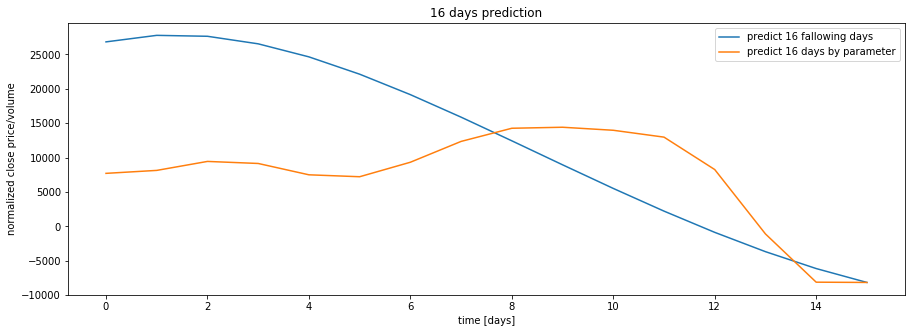

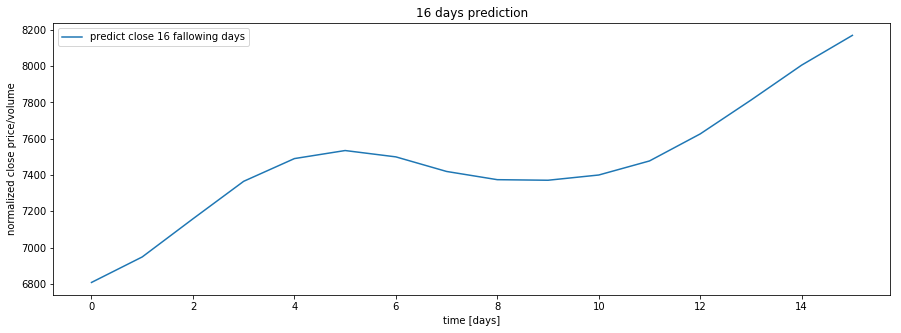

In [18]:
p_f = np.array(p_future)

fx1_close = np.array(last_step)
fx1_close = fx1_close[len(fx1_close) - future_days_predict:,4]

fxc_close = np.array(close_predictions)
fxc_close = fxc_close[len(fxc_close) - future_days_predict:,4]

ftx = np.array(future)
ftx2_close = get_close(ftx[ftx.shape[0] - 5])
ftx2_close = ftx2_close[len(ftx2_close) - future_days_predict:]

plt.figure(figsize=(15, 5));
plt.plot(close_scaler.inverse_transform(close_normal(fx1_close)), label='predict 16 fallowing days')
plt.plot(close_scaler.inverse_transform(close_normal(p_f)), label='predict 16 days by parameter')
# plt.plot(close_scaler.inverse_transform(close_normal(fxc_close)), label='predict close 16 fallowing days')
# plt.plot((ftx2_close), label='predict 16 fallowing days')
plt.title('16 days prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
# plt.plot(close_scaler.inverse_transform(close_normal(fx1_close)), label='predict 16 fallowing days')
plt.plot(close_scaler.inverse_transform(close_normal(fxc_close)), label='predict close 16 fallowing days')
# plt.plot((ftx2_close), label='predict 16 fallowing days')
plt.title('16 days prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()